# Lotka-Volterra Model with `pfmvn`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

In [3]:
import pfjax as pf
from pfjax.particle_filter import particle_filter, particle_loglik, particle_resample_mvn
from pfjax import proj_data, LotVolModel
import pfjax.sde
from pfjax import stoch_opt, get_sum_lweights, get_sum_lweights_mvn

# Simulated Lotvol Data


In [84]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25 # low noise = 0.1
tau_l = 0.25 # low noise = 0.1

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2 # 1, 2, 4, 8, 16
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

In [85]:
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)

In [7]:
def make_df(data_arr, labels):
    """
    FIXME: Only works with resolution size 1
    """
    y_meas = data_arr[0]
    x_state = data_arr[1]
    df = pd.DataFrame(y_meas) 
    df.columns = labels[:2]
    df[labels[2]] = jnp.exp(jnp.squeeze(x_state)[:, 0])
    df[labels[3]] = jnp.exp(jnp.squeeze(x_state)[:, 1])
    df["time"] = df.index
    return df

true_data = make_df([y_meas, x_state],
                    labels=["obs_0", "obs_1", "latent_0", "latent_1"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
sns.lineplot(data=pd.melt(true_data, id_vars = "time"), 
             x="time", y="value", hue="variable")\
    .set_title("Simluated Lotvol data");

### Particle Filter with MVN Approx.


In [6]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]

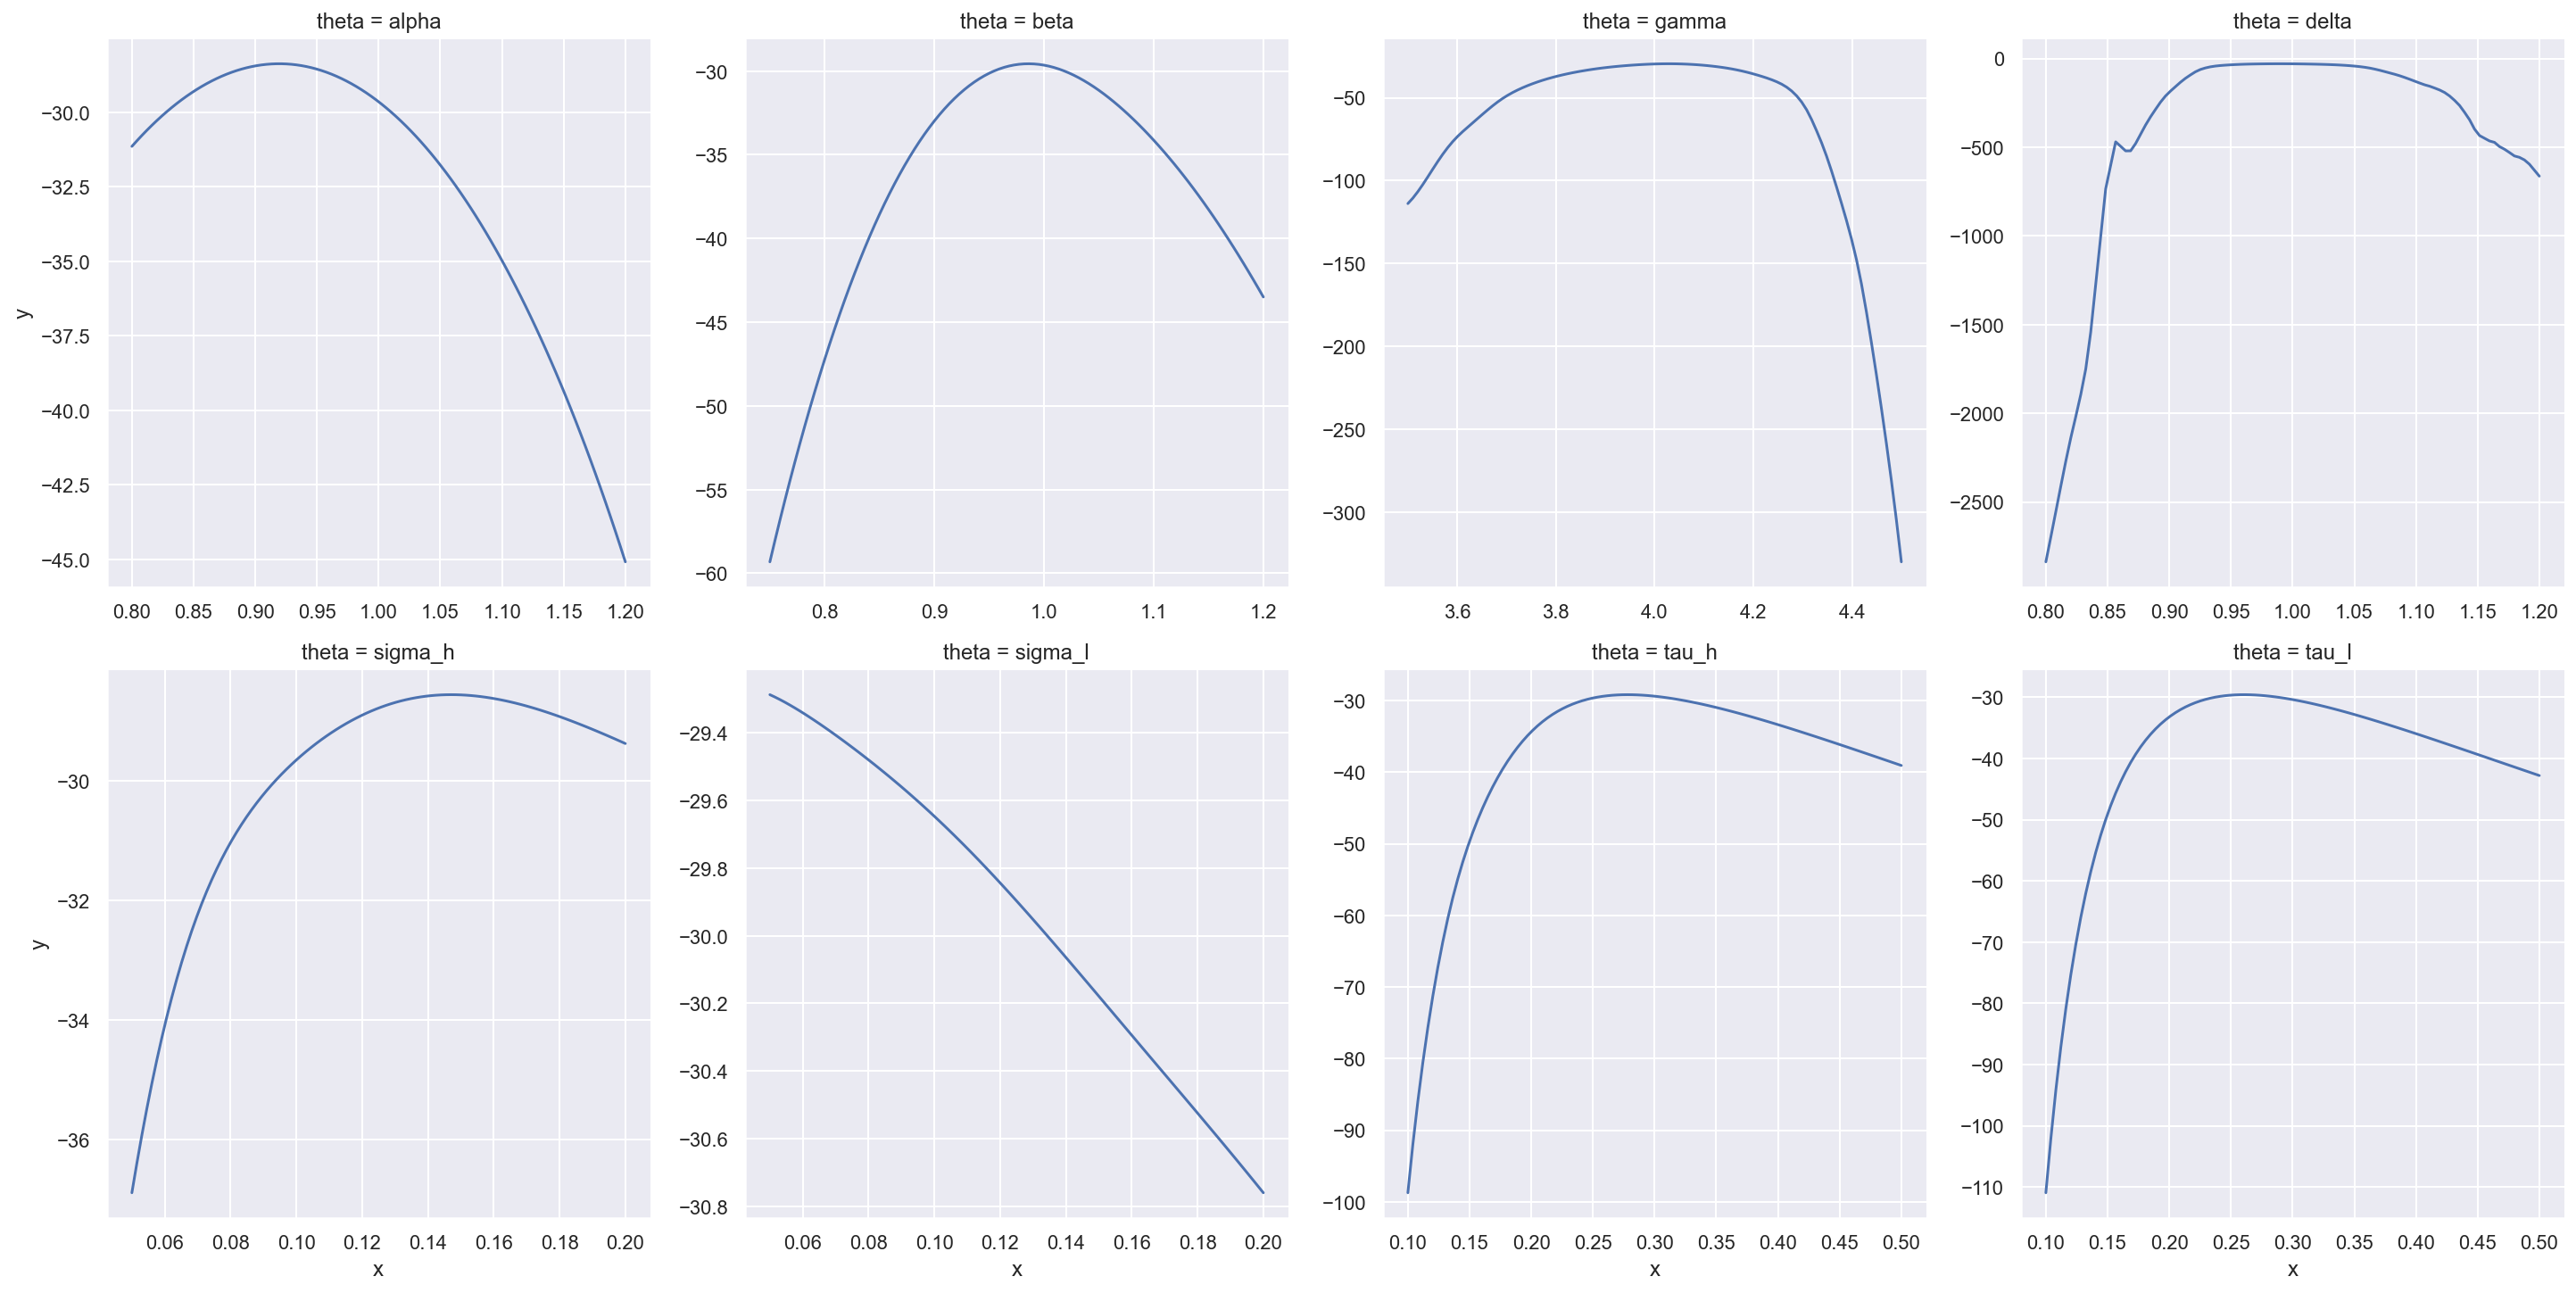

In [9]:
n_particles = 250

@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = particle_resample_mvn)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Bootstrap Particle Filter

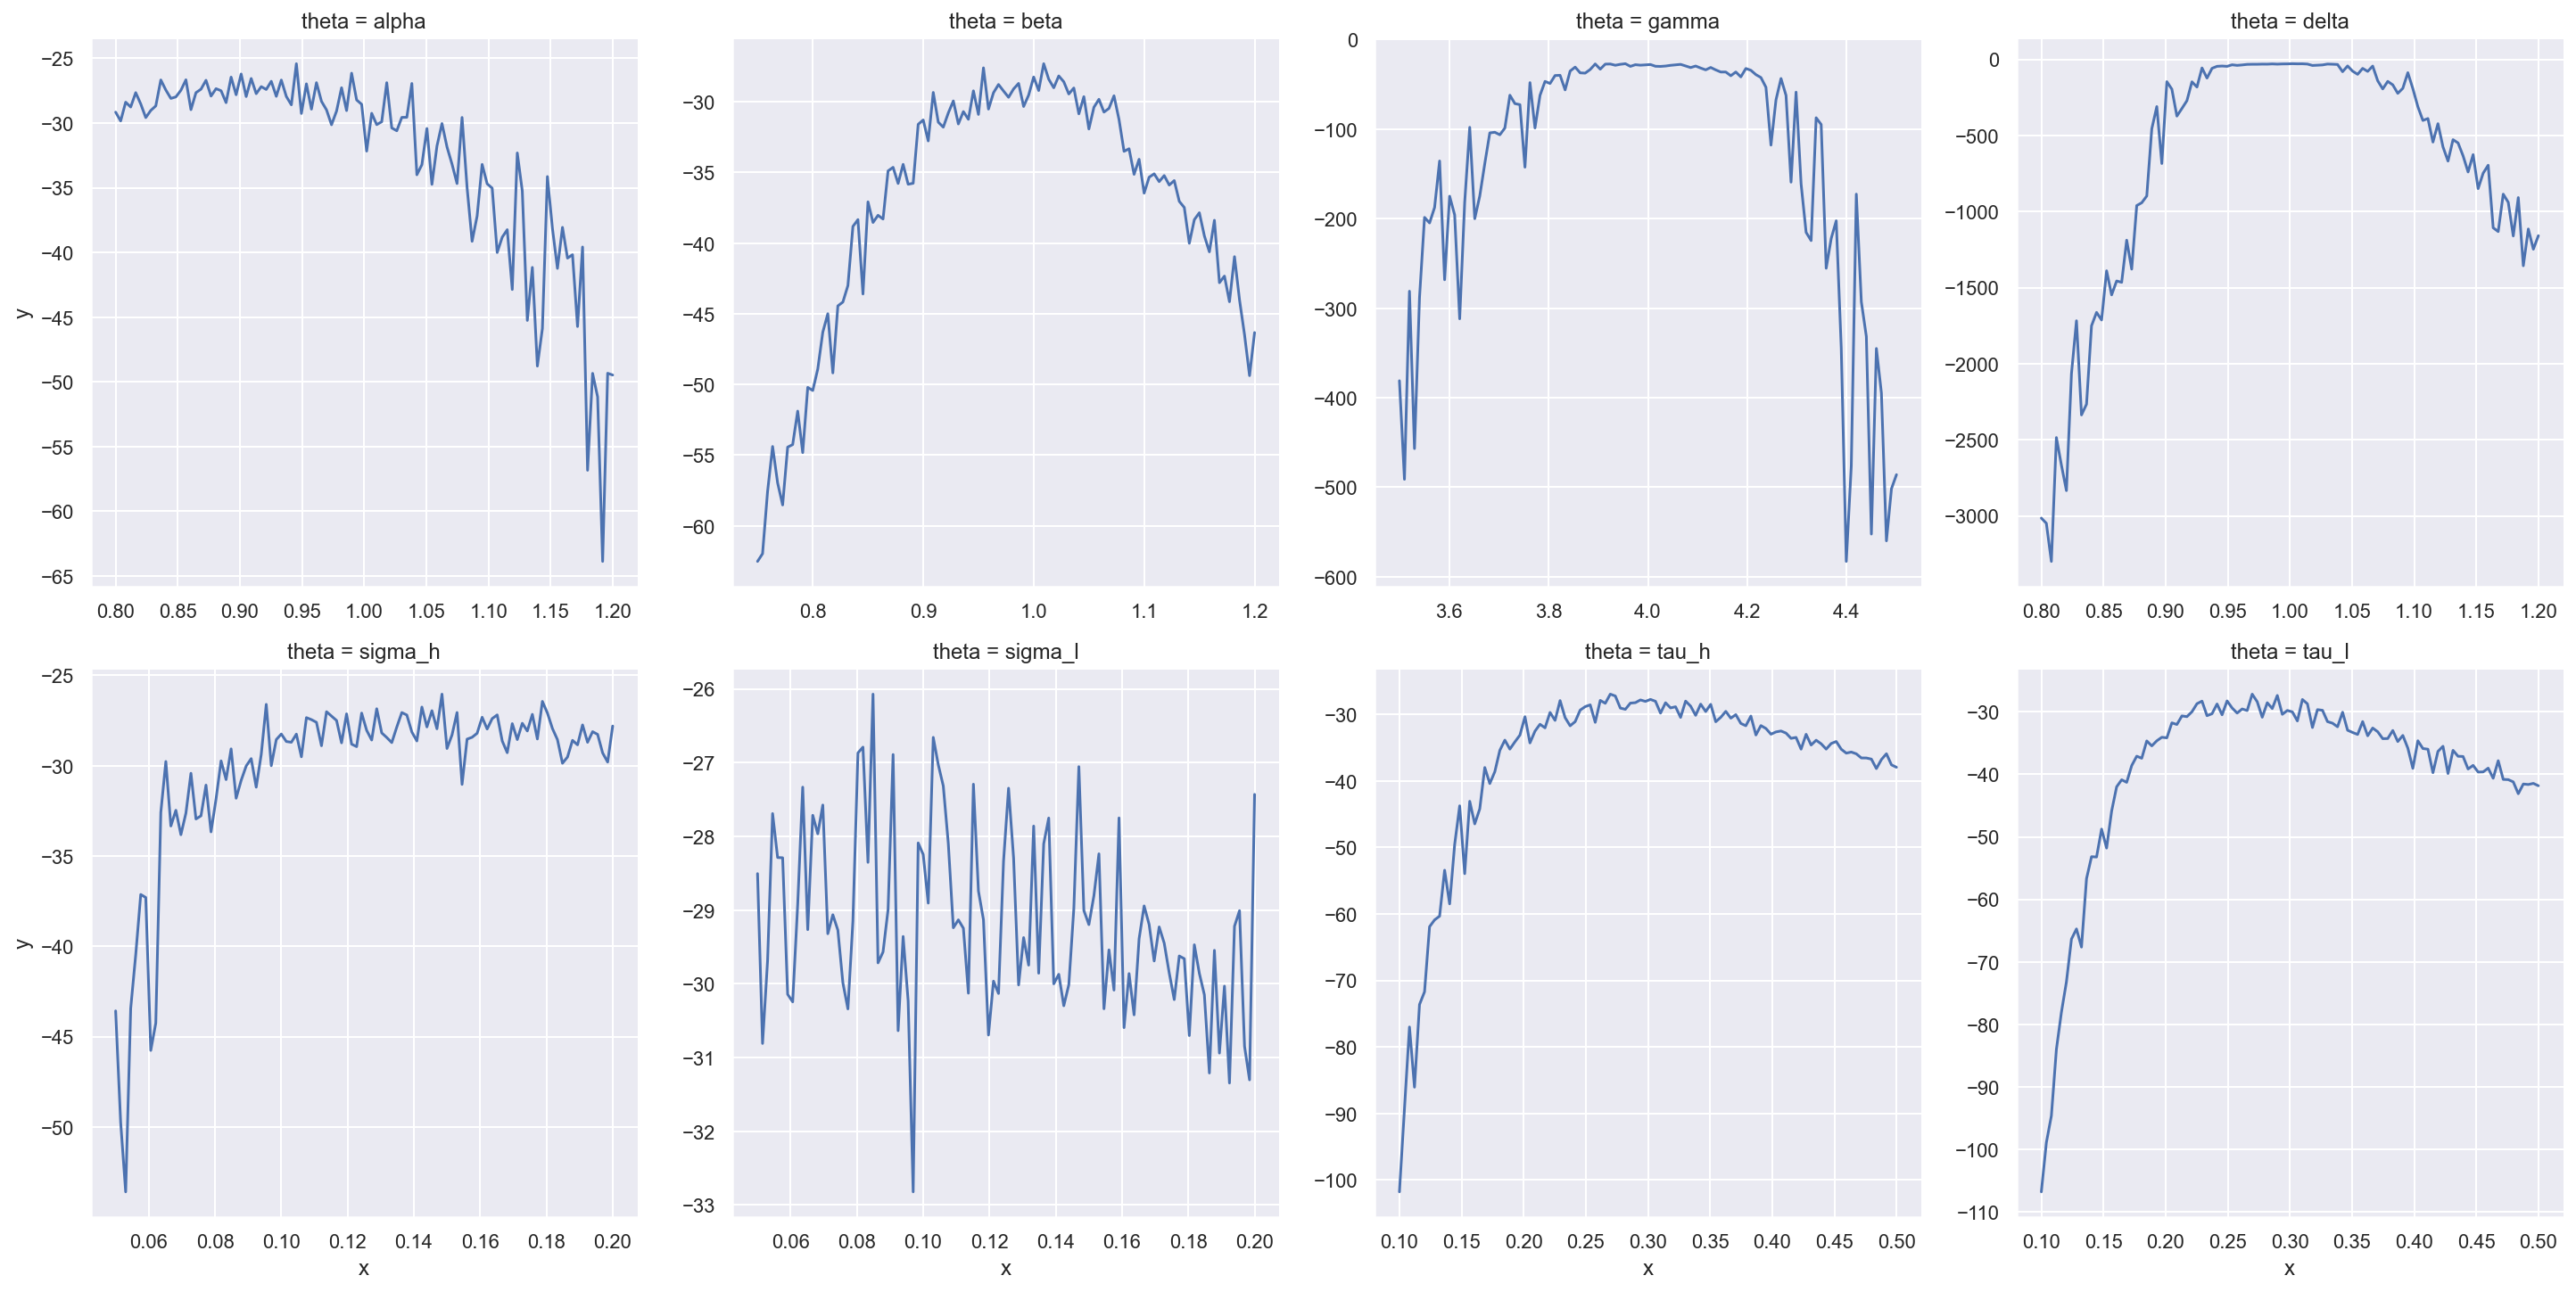

In [10]:
@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, 
                    theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Stochastic Optimization of Parameters

In [7]:
# %%timeit
start =time.perf_counter()

params = stoch_opt(model = lotvol_model, 
                   params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2]), 
                   grad_fun = get_sum_lweights_mvn, 
                   y_meas = y_meas, key=key, 
                   n_particles = 100,
                   learning_rate=1e-5, 
                   iterations=1000,
                   mask=np.array([1,1,1,1,1,1,1,1]))

print("Time: {0}".format(time.perf_counter() - start))
print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/jax/interpreters/xla.py:842: UserWarning: Some donated buffers were not usable: f32[8]{0}
  ", ".join(unused_donations)))


Time: 13.645439707000001
Estimated params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.2, 0.2]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


In [98]:
# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn))
hess = hessian(params,
               key, 
               n_particles=500, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(-hess) 
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

postitive semi-def:  False


ValueError: multivariate_normal requires cov.shape == (..., n, n) for n=6, but got cov.shape == (8, 8).

## Masked Hessian

In [100]:
def get_sum_lweights_mvn_tmp(theta1, theta2, key, n_particles, y_meas, model, rev = False):
    """ take 2nd derivative w.r.t theta1 and fix theta2 (need to be contiguous)"""
    if rev: 
        theta = jnp.concatenate([theta2, theta1])
    else :
        theta = jnp.concatenate([theta1, theta2])
    ret = particle_filter(model = model, y_meas = y_meas, theta = theta, n_particles = n_particles,
                          key = key, particle_sampler=particle_resample_mvn)
    sum_particle_lweights = particle_loglik(ret['logw'])
    return sum_particle_lweights

hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn_tmp, argnums=0), argnums=0)

postitive semi-def:  True


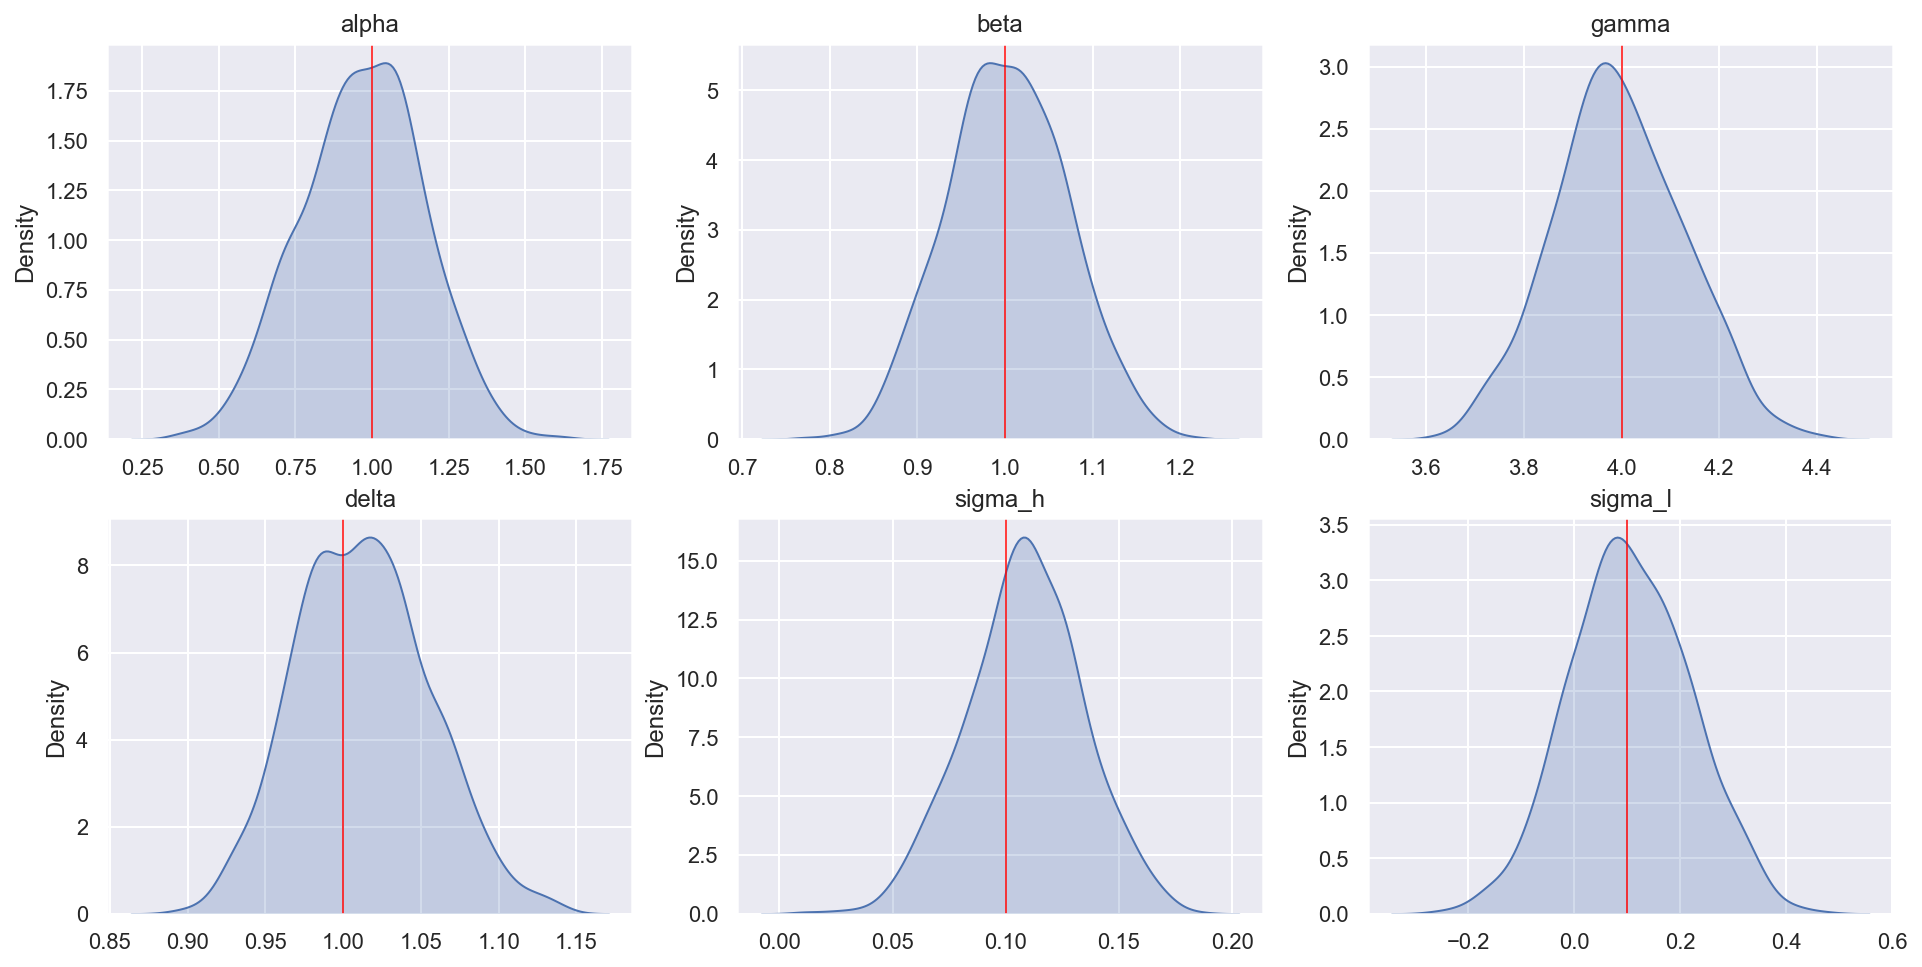

In [107]:
theta_hat = params[:6]
hess = hessian(theta_hat, params[6:],
               key, 
               n_particles=5000, # doesnt work with 1000 particles... ??
               y_meas=y_meas, 
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=var_hat, shape=(1_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

# Inference with Real Data - Low Noise Setting

Using Michelle's data:

#### Resolution Size = 1

In [120]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 
theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

key = random.PRNGKey(0)

dt = 0.1
n_res = 4
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

_y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

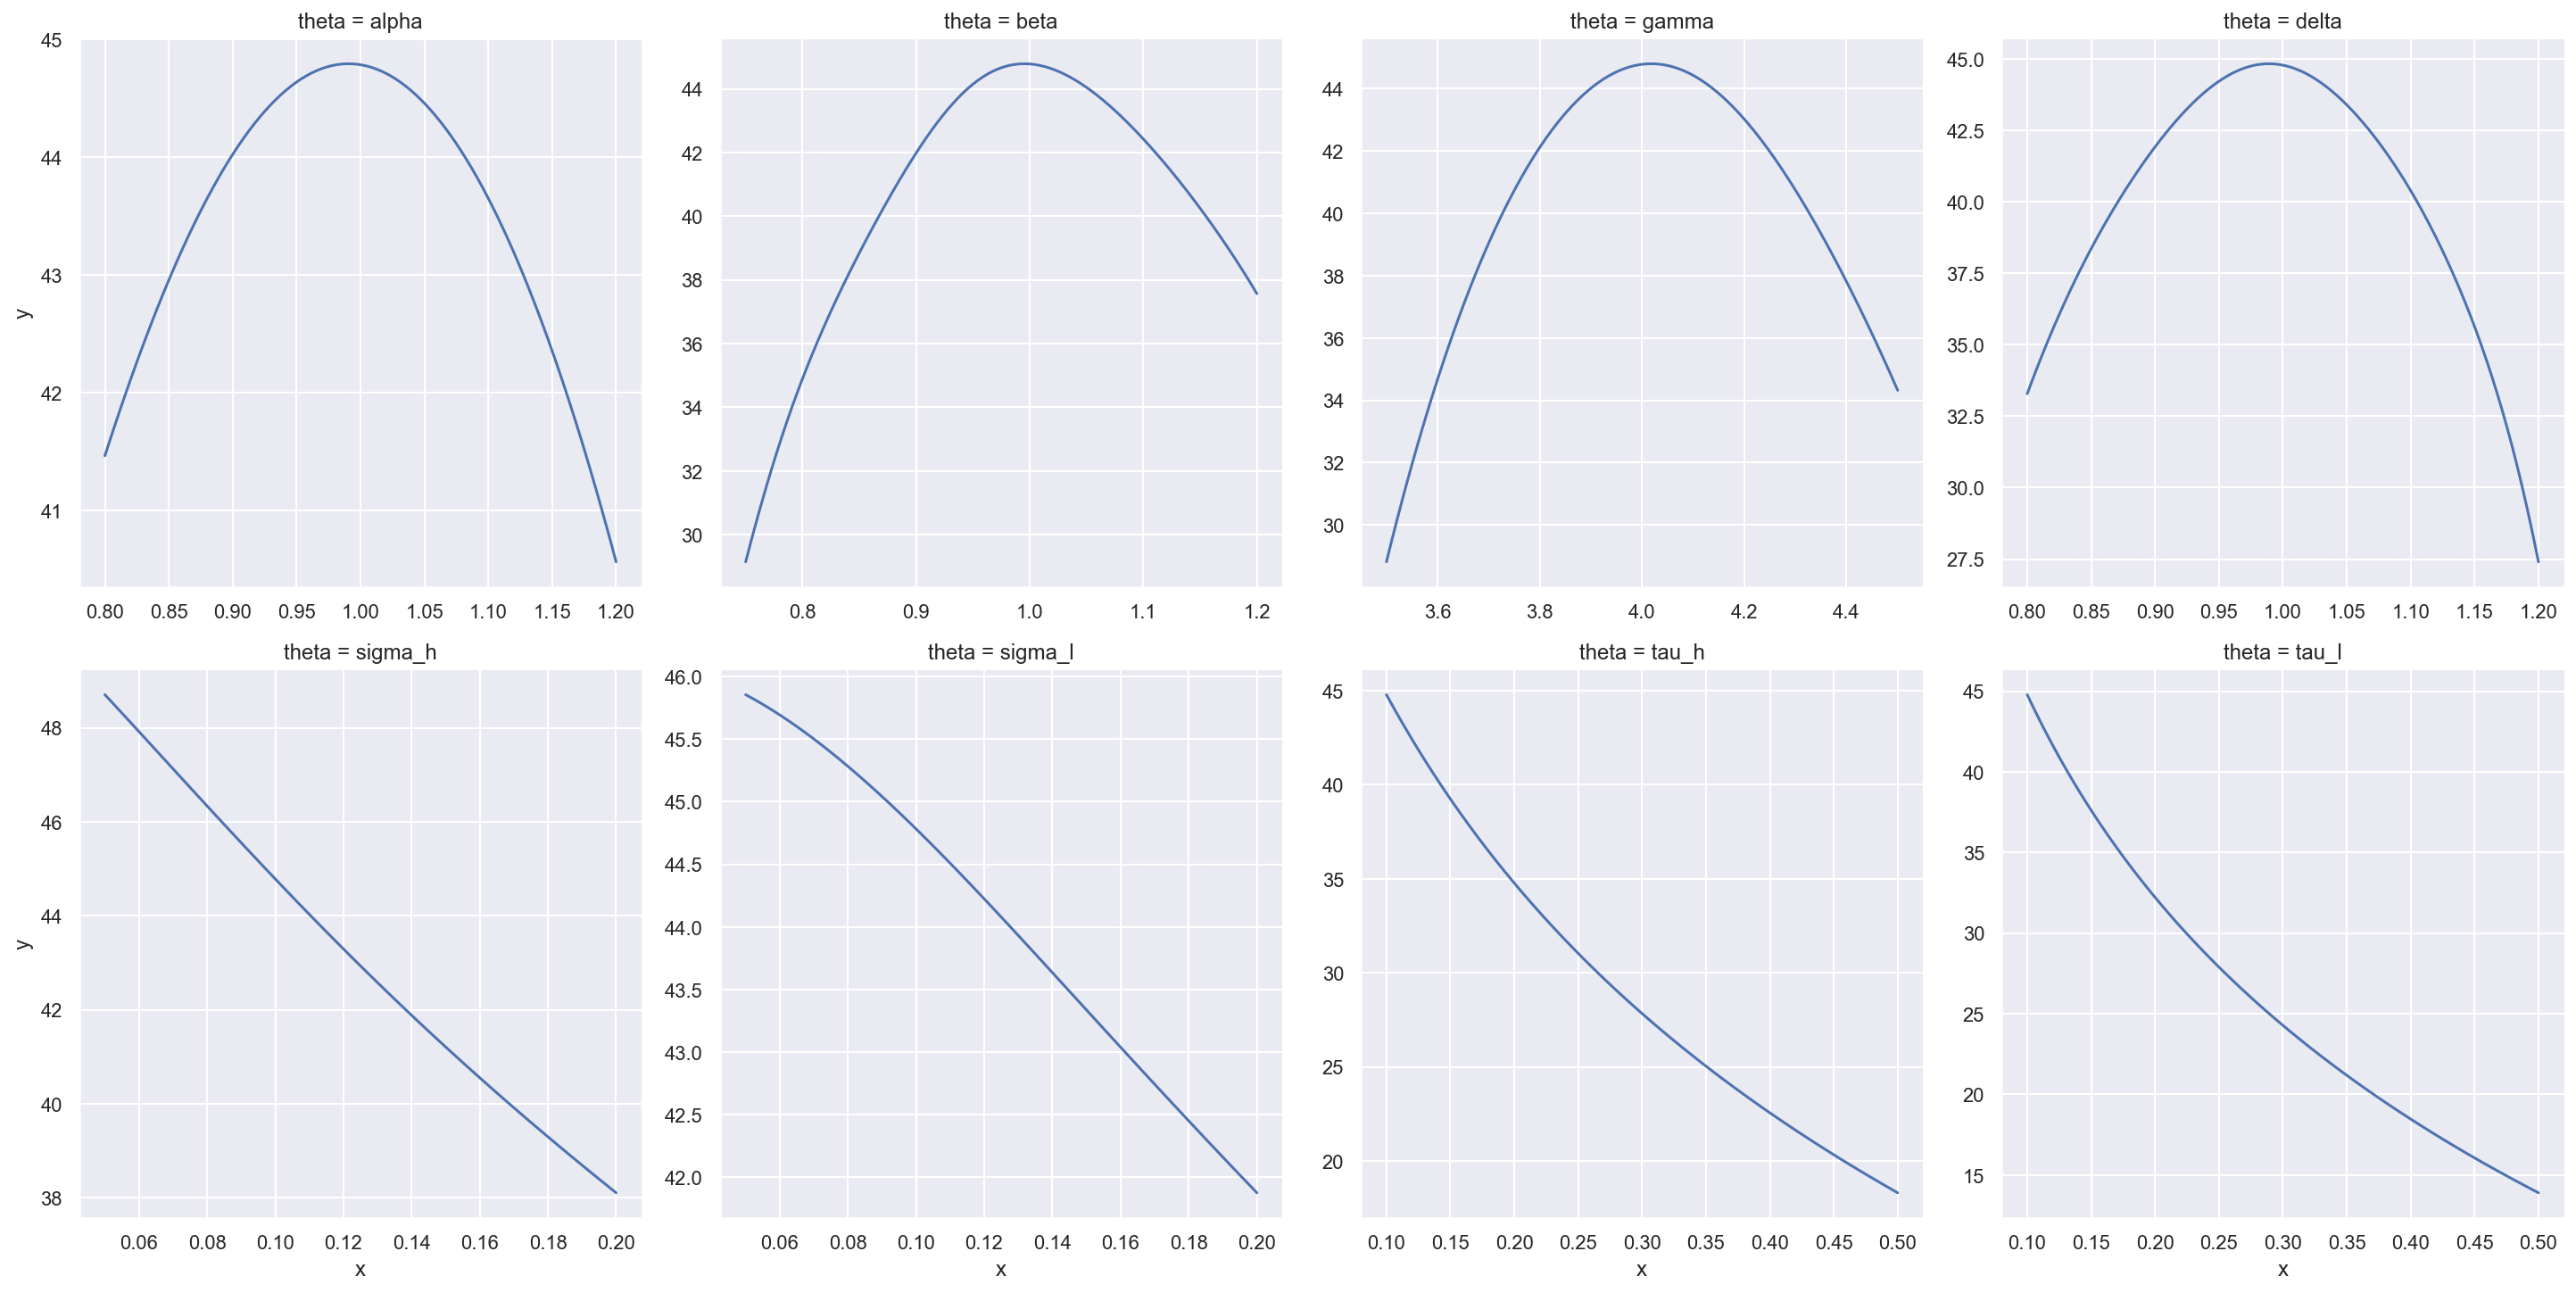

In [121]:
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, 
                           model=lotvol_model, 
                           y_meas = y_meas,
                           n_particles=n_particles,
                           particle_sampler = particle_resample_mvn,
                           key=key)
    return particle_loglik(temp['logw'])

plot_df = proj_data(fun = lotvol_pflik, theta = theta, 
                    theta_lims = theta_lims, 
                    theta_names = theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

In [122]:
params = stoch_opt(model = lotvol_model, 
                   params = jnp.array([1.,1., 4., 1., 0.1, 0.1, tau_h, tau_l]), 
                   grad_fun = get_sum_lweights_mvn, 
                   y_meas = y_meas, 
                   key=key, 
                   n_particles = 100,
                   learning_rate=1e-5, 
                   iterations=1000,
                   mask=np.array([1,1,1,1,1,1,1,1]))
params

/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/jax/interpreters/xla.py:842: UserWarning: Some donated buffers were not usable: f32[8]{0}
  ", ".join(unused_donations)))


DeviceArray([0.9974966 , 1.0046663 , 3.9905272 , 1.0098734 , 0.10999868,
             0.10999868, 0.10999868, 0.10999868], dtype=float32)

postitive semi-def:  False


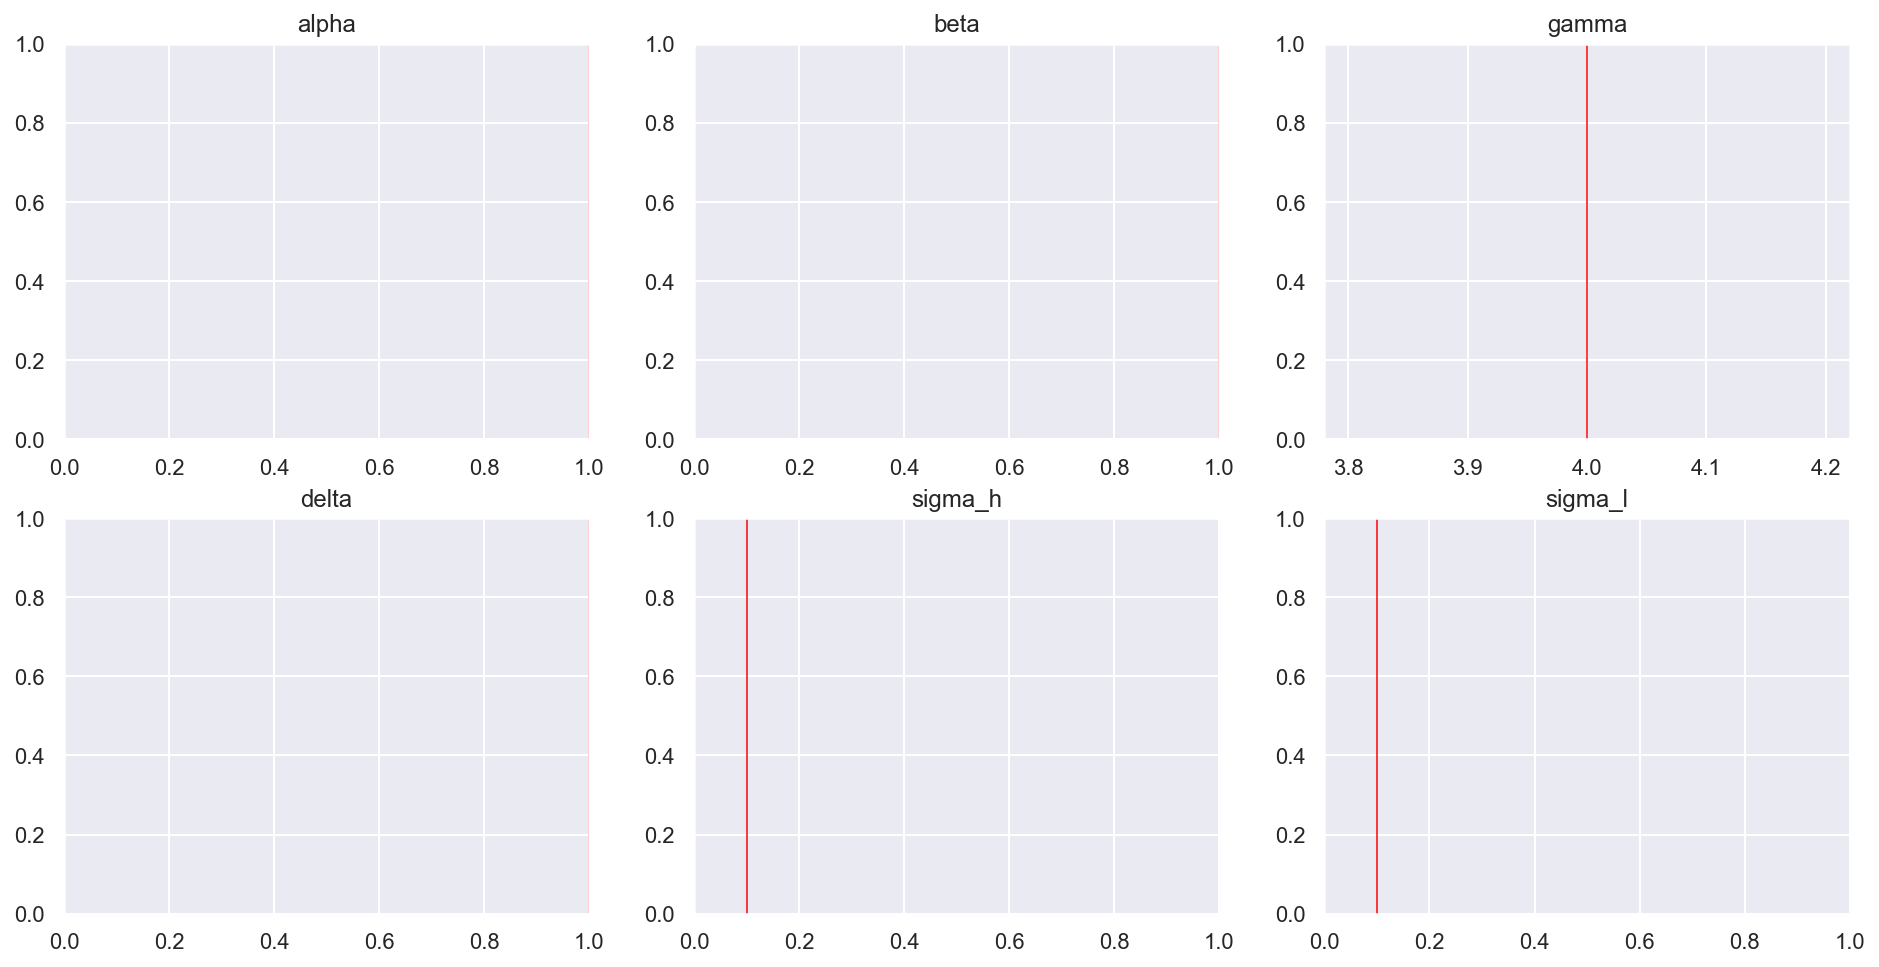

In [131]:
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn_tmp))
theta_hat = params[:5]
hess = hessian(theta_hat, params[5:],
               key, 
               n_particles=50_000, # doesnt work with 1000 particles... ??
               y_meas=y_meas, 
               model=lotvol_model)

# theta_hat = params
var_hat = np.array(jnp.linalg.inv(-hess)) # + jnp.diag(jnp.ones(len(theta_hat)))*0.05

print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [130]:
np.round(np.diag(hess))

array([-146., -341.,  -76., -503.,   16.], dtype=float32)

# Inference with Real Data - High Noise Setting

Using Michelle's data:

#### Resolution Size = 2

In [232]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25
theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

key = random.PRNGKey(0)

dt = 0.1
n_res = 2
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

_y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

In [233]:
params = stoch_opt(model = lotvol_model, 
                   params = jnp.array([1.,1., 4., 1., 0.1, 0.1, tau_h, tau_l]), 
                   grad_fun = get_sum_lweights_mvn, 
                   y_meas = y_meas, 
                   key=key, 
                   n_particles = 100,
                   learning_rate=1e-7, 
                   iterations=1000,
                   mask=np.array([1,1,1,1,1,1,0,0]))
params

DeviceArray([0.9998808 , 1.0001192 , 4.        , 1.0001192 , 0.10009686,
             0.10009686, 0.25      , 0.25      ], dtype=float32)

postitive semi-def:  False


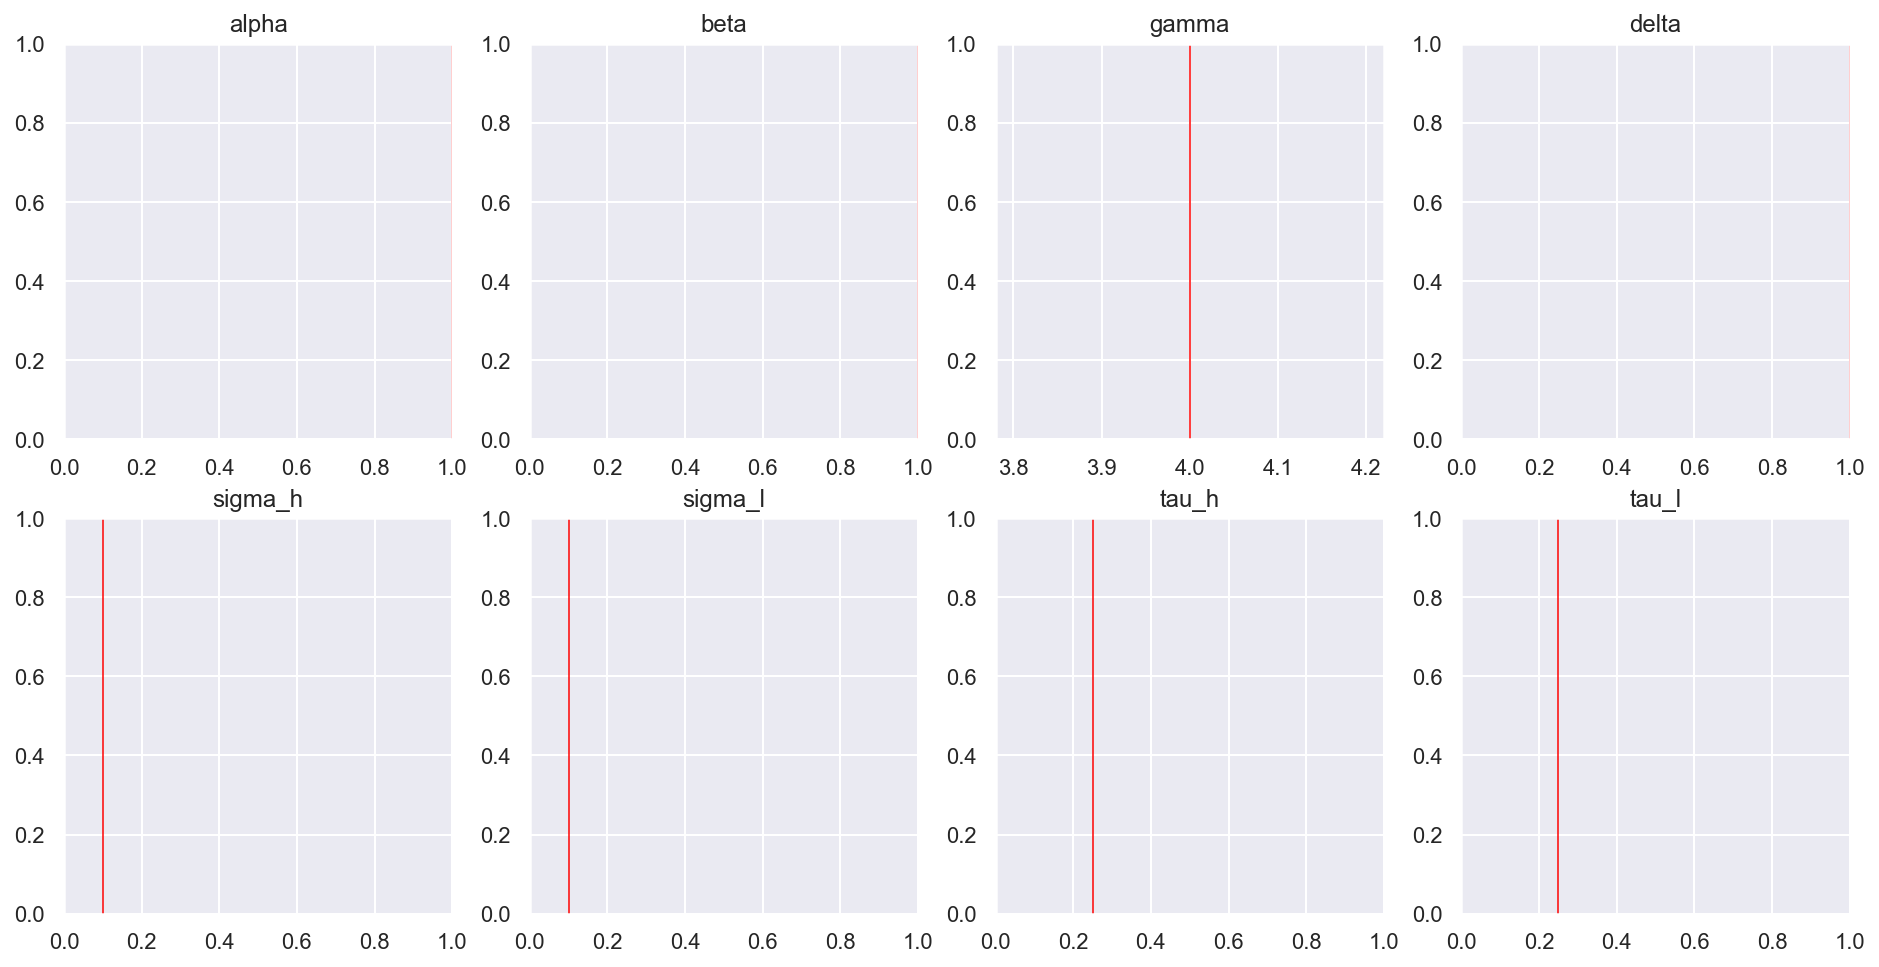

In [35]:
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights_mvn))
hess = hessian(params,
               key, 
               n_particles=5_000,
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(-var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

# -- DONTRUN TESTS ---

In [13]:
hessian = jax.jacfwd(jax.jacrev(pfmvn.get_sum_lweights_mvn))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)

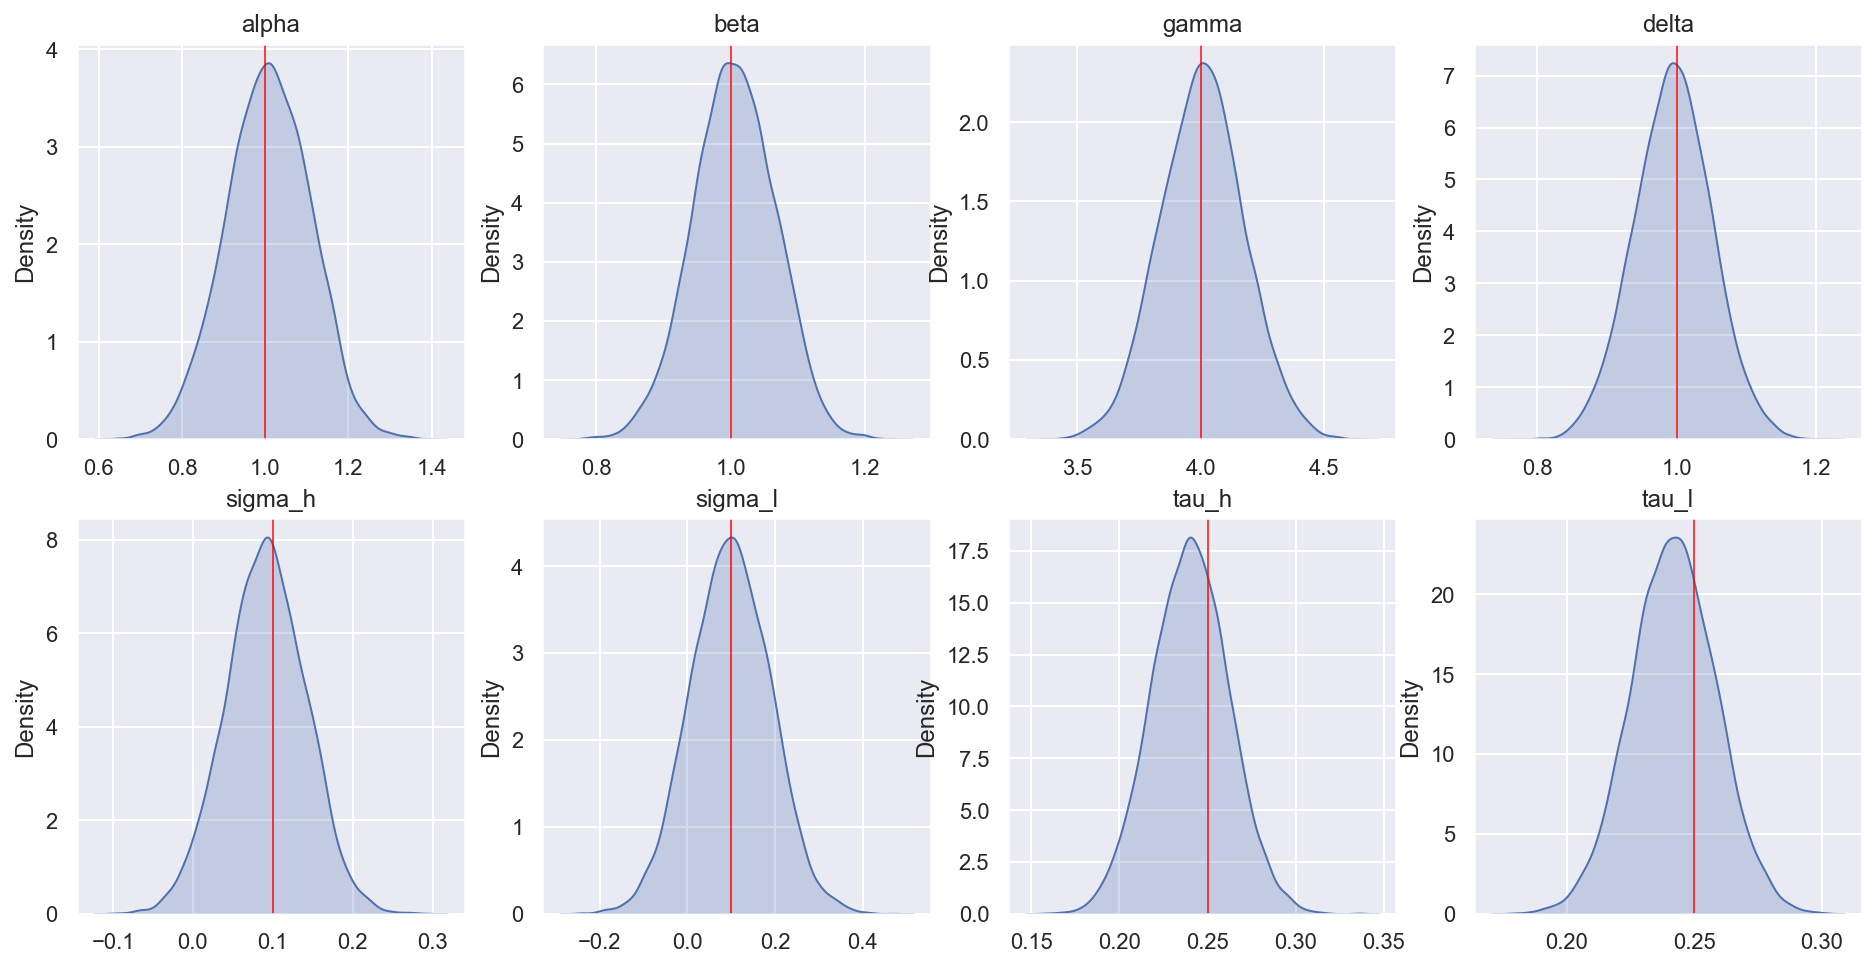

In [14]:
mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]

for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Full Posterior: log-lik + prior

In [10]:
from jax.scipy.stats import multivariate_normal 
from jax import random

prior_means = theta
prior_cov = jnp.diag(theta)

def prior(x): 
    # will have to change this to use Jax sampling
    return multivariate_normal.pdf(
    x, prior_means, prior_cov)

In [14]:
# %%timeit
start = time.perf_counter()
params, so, grads = stoch_opt(lotvol_model,
                              params=jnp.array(
                                  [1., 1., 4., 1., 0.1, 0.1, 0.25, 0.25]),
                              #   params=jnp.array(np.random.random(len(theta))*0.01),
                              grad_fun=pfmvn.log_posterior,
                              y_meas=y_meas, key=key,
                              learning_rate=1e-5, iterations=1000,
                              n_particles=100,
                              mask=np.array([1, 1, 1, 1, 1, 1, 1, 1]),
                              prior=prior)
print("Time: {0}".format(time.perf_counter() - start))
# print("Estimated params: {0}".format(list(round(params, 1))))
# print("True params: {0}".format(list(theta)))


Time: 12.18306301900003


In [15]:
%%timeit
# hessian: 
hessian = jax.jacfwd(jax.jacrev(pfmvn.log_posterior))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
start = time.perf_counter()
hess = hessian(params, key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model, 
               prior=prior)
print("Time: {0}".format(time.perf_counter() - start))

theta_hat = params
var_hat = jnp.linalg.inv(hess)

Time: 34.08387946099998
Time: 25.799432801000023
Time: 26.936572599999977
Time: 25.45797890900002
Time: 23.96301673800002
Time: 23.65608342400003
Time: 23.699931765999963
Time: 23.666503850000026
24.7 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
n_post_samples = 2000
posterior_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(n_post_samples, ))

# find 95% credible intervals
theta_U = jnp.quantile(posterior_samples, q=0.95, axis=0)
theta_L = jnp.quantile(posterior_samples, q=0.05, axis=0)

round(theta_L, 2), round(theta_U, 2)

theta_L = jnp.array(list(map(lambda x: max(x, 1e-4), theta_L))) # trickery to remove negative values from lower bound

(DeviceArray([ 0.84      ,  0.94      ,  3.59      ,  0.90999997,
              -0.03      , -0.08      ,  0.25      ,  0.22      ],            dtype=float32),
 DeviceArray([0.93, 1.04, 4.23, 1.05, 0.03, 0.14, 0.35, 0.31], dtype=float32))

In [22]:
# forward simulate data with lower confidence interval:
x_init_L = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_L,
                                    key=subkey)

y_meas_L, x_state_L = simulate(lotvol_model,
                               n_obs,
                               x_init_L,
                               theta_L,
                               subkey)
lower_bound = make_df([y_meas_L, x_state_L], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

# forward simulate data with upper confidence interval:
x_init_U = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_U,
                                    key=subkey)

y_meas_U, x_state_U = simulate(lotvol_model,
                               n_obs,
                               x_init_U,
                               theta_U,
                               subkey)
upper_bound = make_df([y_meas_U, x_state_U], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

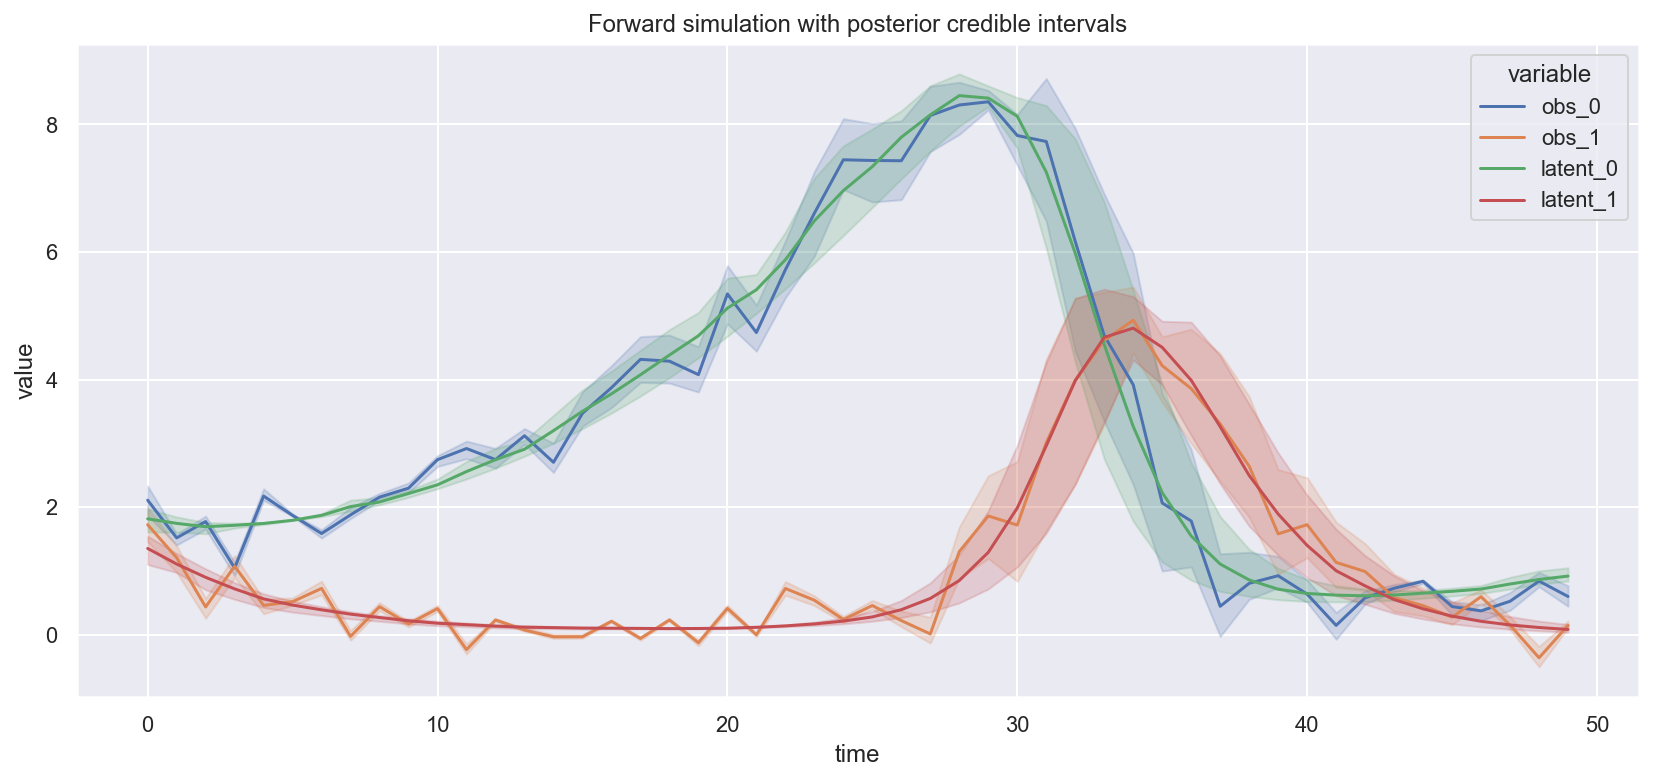

In [23]:
all_data = pd.concat([lower_bound, upper_bound, true_data]
                     ).reset_index(drop=True)
all_data = pd.melt(all_data, id_vars="time")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharey=True)
sns.lineplot(data=all_data, x="time", y="value", hue="variable")\
    .set_title("Forward simulation with posterior credible intervals");